In [1]:
from data_tools import query
from data_tools.collections import TimeSeries
import numpy as np
import matplotlib.pyplot as plt
from data_tools import FSGPDayLaps
from scipy.interpolate import make_interp_spline

day_1 = FSGPDayLaps(1)
start_time = day_1.get_start_utc(1)
stop_time = day_1.get_finish_utc(day_1.get_lap_count())
start_time, stop_time

(datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2024, 7, 16, 20, 39, 40, tzinfo=datetime.timezone.utc))

In [2]:
client = query.DBClient()

speed: TimeSeries = client.query_time_series(start_time, stop_time, "VehicleVelocity")
accelator_percent: TimeSeries = client.query_time_series(start_time, stop_time, "AcceleratorPosition")
brake_pressed: TimeSeries = client.query_time_series(start_time, stop_time, "MechBrakePressed")
regen_enabled: TimeSeries = client.query_time_series(start_time, stop_time, "RegenEnabled")

In [9]:
acceleration = np.gradient(speed, speed.period)
accelator_percent, brake_pressed, regen_enabled, speed, acceleration = speed.align(accelator_percent, brake_pressed, regen_enabled, speed, acceleration)

cruising_mask = np.logical_and(
    np.asarray(brake_pressed) == 0,
    np.logical_and(accelator_percent == 0, speed > 1)
)

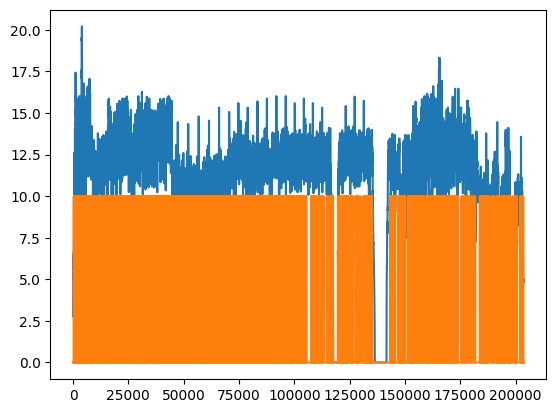

In [10]:
plt.plot(speed)
plt.plot(cruising_mask * 10)
plt.show()

In [35]:
car_mass_kg = 350

cruising_speeds = speed[cruising_mask]
cruising_forces = acceleration[cruising_mask] * car_mass_kg

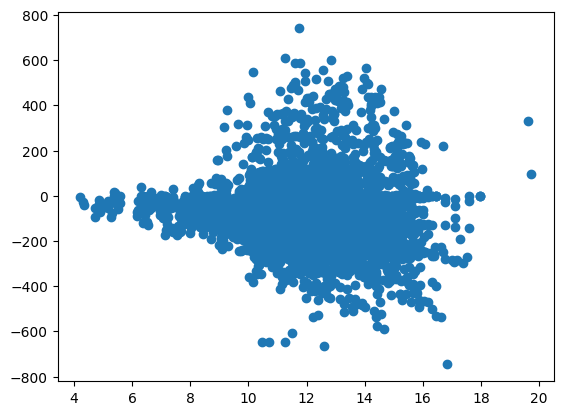

In [36]:
plt.scatter(cruising_speeds, cruising_forces)
plt.show()

In [37]:
sorted_indices = np.argsort(cruising_speeds)
sorted_speeds = cruising_speeds[sorted_indices]
sorted_forces = cruising_forces[sorted_indices]

From ubc-solar-physics BasicMotor.calculate_net_force:
```
required_speed_ms = required_speed_kmh / 3.6

acceleration_ms2 = np.clip(np.gradient(required_speed_ms), a_min=0, a_max=None)
acceleration_force = acceleration_ms2 * self.vehicle_mass

required_angular_speed_rads = required_speed_ms / self.tire_radius

drag_forces = 0.5 * self.air_density * (
        (required_speed_ms + wind_speeds) ** 2) * self.drag_coefficient * self.vehicle_frontal_area

angles = np.arctan(gradients)
g_forces = self.vehicle_mass * self.acceleration_g * np.sin(angles)

road_friction_array = self.road_friction * self.vehicle_mass * self.acceleration_g * np.cos(angles)

net_force = road_friction_array + drag_forces + g_forces + acceleration_force
```
Assuming we are driving on a flat surface, we get that `angles` are zero. Therefore:
```
-acceleration_force == drag_forces + road_friction_array
-acceleration_force == (0.5 * self.air_density * (
        (required_speed_ms + wind_speeds) ** 2) * self.drag_coefficient * self.vehicle_frontal_area) + (self.road_friction * self.vehicle_mass * self.acceleration_g)
```

We roughly have:

$F_{drag}=\frac12 \rho v^2 C_D A$

$F_{road_friction} = C_R w = C_R m g$

with:

road_friction = 0.012

vehicle_frontal_area = 1.1853

drag_coefficient = 0.11609

In [38]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

road_friction = 0.012
vehicle_frontal_area = 1.1853
drag_coefficient = 0.11609
AIR_DENSITY = 1.225

def cruising_forces_fit_func(v, drag_scale=1, friction_scale=1):
    drag_force = 0.5 * AIR_DENSITY * drag_coefficient * vehicle_frontal_area * v**2
    rolling_friction_force = car_mass_kg * 9.81 * road_friction
    return -drag_force * drag_scale - rolling_friction_force * friction_scale

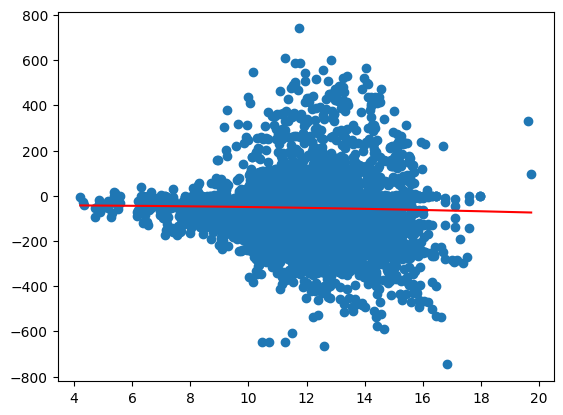

In [39]:
plt.scatter(sorted_speeds, sorted_forces)
plt.plot(sorted_speeds, cruising_forces_fit_func(sorted_speeds), color='red')
plt.show()

In [40]:
popt, pcov  = curve_fit(cruising_forces_fit_func, sorted_speeds, sorted_forces)
drag_scale, friction_scale = popt
drag_scale, friction_scale

(np.float64(3.138238777892), np.float64(0.7436851438619391))

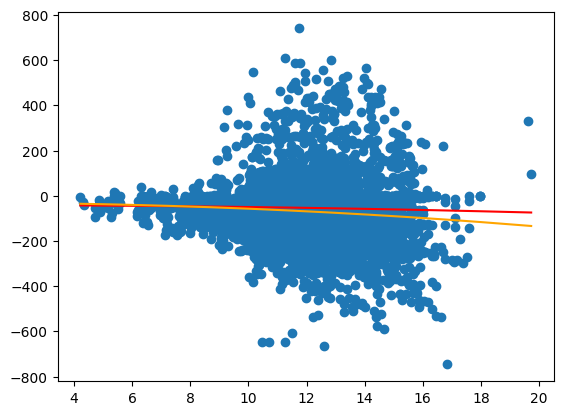

In [41]:
plt.scatter(sorted_speeds, sorted_forces)
plt.plot(sorted_speeds, cruising_forces_fit_func(sorted_speeds, 1, 1), color='red')
plt.plot(sorted_speeds, cruising_forces_fit_func(sorted_speeds, drag_scale, friction_scale), color='orange')
plt.show()